In [1]:
# import relevant modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import datetime
from datetime import date
from datetime import timedelta
import seaborn as sns

### Q1 ###

For question one, we extract the runoff data from the location of the Tokuyama dam using bilinear interpolation methods in cdo.

This is after the ERA5 data has been unzipped and combined into one file using cdo mergetime.

In [ ]:
%%sh

# remap using bilinear interpolation
cdo remapbil,lon=136.47642/lat=35.63422 japan_ERA5land_20170601-20190801.nc japan_ERA5land_20170601-20190801_tokuyama.nc

# take the day mean of the data 
cdo daymean japan_ERA5land_0801_tokuyama.nc tokuyama_daymean.nc

### Q3 ###

To prepare the data for comparison in Q3, we have to convert the forecast runoff data (in kg m $^{-2}$ ) to the ERA5 units (m). We have to find the difference between time steps for each ensemble member in each file.

In [ ]:
%%sh

# we want to loop over all of the PF files:
for i in japan_ECMF_PF.????????.nc; do

    # extract the date from the file name
    date=$(echo $i | cut -d'.' -f2)

    # initialise the for loop to loop over all of the ensemble members
    for j in {1..50}; do

        # extract the runoff data for the current ensemble member
        cdo selname,ro -sellevel,$j $i japan_ECMF_PF.$date.$j.nc

        # calculate the difference between the runoff at the current time step and the runoff at the previous time step within the file
        cdo -b f64 deltat japan_ECMF_PF.$date.$j.nc japan_ECMF_PF.$date.$j.diff.nc

        # remove the temporary files
        rm japan_ECMF_PF.$date.$j.nc

    done

    # calculate the mean over all of the ensemble members
    cdo ensmean japan_ECMF_PF.$date.*.diff.nc japan_ECMF_PF.$date.diff.nc

    # remove the temporary files
    rm japan_ECMF_PF.$date.*.diff.nc

done

# combine all of the PF diff files into one file
cdo mergetime japan_ECMF_PF.*.diff.nc japan_ECMF_PF.diff.nc

# select the study area
cdo sellonlatbox,135,137,34,36 japan_ECMF_PF.diff.nc japan_ECMF_PF.diff.study_area.nc

This data contains overlaps, so we will use xarray tools to deal with these.

Where there are multiple values for one day (from overlapping forecast dates), we will take the average of these values to get one value per day.

In [ ]:
%%python3

# define a function which will import and process the S2S data
def S2S_data(filename):
    """Load the data from a NetCDF file, converts the units and removes negative values. Also groups the data by the time coordinate and takes the mean."""

    # load the data
    data = xr.open_dataset(filename)

    # replace all values less than 0 with 0
    data['ro'] = data['ro'].where(data['ro'] > 0, 0)

    # convert the runoff to the same units as the ERA5 data
    # we will do this by dividing by 1000
    data['ro'] = data['ro']/1000

    # group the data by the time coordinate and take the mean
    averaged_data = data.groupby('time').mean(dim='time')

    # save the averaged data to a new NetCDF file
    averaged_data.to_netcdf(filename[:-3] + '_overlap_mean.nc')

# call the function
S2S_data(r'japan_ECMF_PF.diff.study_area.nc')


For the statistical comparison in Q3, we also have to downscale the ERA5 data to a more coarse resolution and then select our gridbox which we average over.

In [ ]:
%%sh

# regridding ERA5 data to the same grid as the ECMWF S2S data
cdo remapbil,japan_ECMF_PF.20190627.nc "/home/users/benhutch/MTMG50/MTMG50-Technical-Assignment/japan_ERA5land_20170601-20190801.nc" "/home/users/benhutch/MTMG50/S2S/ecmwf/japan_ERA5land_20170601-20190801_coarse.nc"

# subset the coasre ERA5 data to the same domain as the ECMWF S2S data
cdo sellonlatbox,135,137,34,36 japan_ERA5land_20170601-20190801_coarse.nc japan_ERA5land_20170601-20190801_coarse_subset.nc

For the statistical comparison of the uncalibrated data in Q3, we will use seaborn to plot the PDFs, means, and standard deviation values to compare the two datasets.

When we are plotting the PDF results, we only consider the ERA5 data when there is S2S forecast data available for the same day. These time periods include:

* 2017-06-01 to 2017-09-15

* 2018-06-04 to 2018-09-14

* 2019-06-03 to 2019-09-13



c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


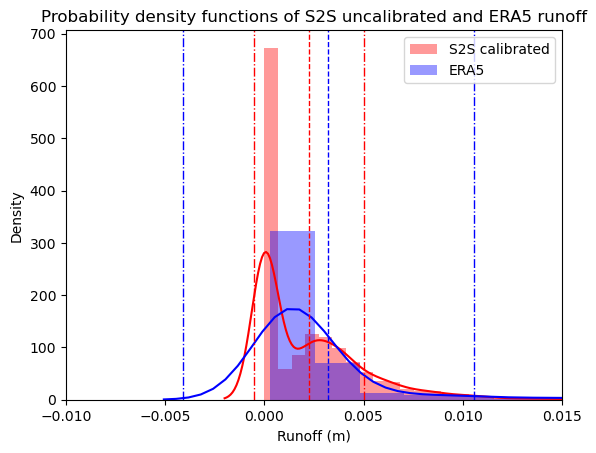

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import date
from datetime import timedelta

# define the paths to the data
uncal_S2S = r'C:\Users\Ben Hutchins\OneDrive - University of Reading\Documents\GitHub\MTMG50-Technical-Assignment\japan_ECMF_PF.diff.study_area_overlap_mean.nc'
era5_grid = r'C:\Users\Ben Hutchins\OneDrive - University of Reading\Documents\GitHub\MTMG50-Technical-Assignment\japan_ERA5land_20170601-20190801_coarse_subset.nc'

title = 'Probability density functions of S2S uncalibrated and ERA5 runoff'
fig_name = 'PDFs_S2S_uncalibrated_ERA5.png'

# define a function to prepare the ERA5 data
def ERA5_data_matchup(filename):
    """Condenses the ERA5 data to the same temporal range(s) as the S2S data."""

    # load the data (after it has been opened with xarray)
    era5 = filename

    # specify the start and end dates for the different periods

    # 2017
    start_date_2017 = '2017-06-01'
    end_date_2017 = '2017-09-15'

    # 2018
    start_date_2018 = '2018-06-04'
    end_date_2018 = '2018-09-14'

    # 2019
    start_date_2019 = '2019-06-03'
    end_date_2019 = '2019-09-13'

    # slice for the 2017 data
    era5_2017 = era5.sel(time=slice(start_date_2017, end_date_2017))

    # slice for the 2018 data
    era5_2018 = era5.sel(time=slice(start_date_2018, end_date_2018))

    # slice for the 2019 data
    era5_2019 = era5.sel(time=slice(start_date_2019, end_date_2019))

    # combine the data into one dataset
    era5_matchup = xr.concat([era5_2017, era5_2018, era5_2019], dim='time')

    # return the data
    return era5_matchup

# define a function to import the data
# and plot the probability density functions/histograms
def plot_PDFs(S2S, ERA5, title, fig_name, calibrate=False, c1=0, c0=0):
    """Load the data from the NetCDF files and plot the probability density functions/histograms on the same plot."""

    # load the data
    data = xr.open_dataset(S2S)
    era5 = xr.open_dataset(ERA5)

    # prepare the ERA5 data
    era5 = ERA5_data_matchup(era5)

    # optional calibration
    if calibrate == True:
        data = data*c1 + c0
    else:
        pass
    
    # plot the two distributions on the same plot
    sns.distplot(data['ro'].values.flatten(), label='S2S calibrated', color = 'red')
    sns.distplot(era5['ro'].values.flatten(), label='ERA5', color = 'blue')

    # plot the means as vertical lines
    plt.axvline(data['ro'].values.flatten().mean(), color='red', linestyle='dashed', linewidth=1)
    plt.axvline(era5['ro'].mean(), color='blue', linestyle='dashed', linewidth=1)

    # include the standard deviations

    # S2S
    plt.axvline(data['ro'].values.flatten().mean() + data['ro'].values.flatten().std(), color='red', linestyle='-.', linewidth=1)
    plt.axvline(data['ro'].values.flatten().mean() - data['ro'].values.flatten().std(), color='red', linestyle='-.', linewidth=1)

    # ERA5
    plt.axvline(era5['ro'].mean() + era5['ro'].std(), color='blue', linestyle='-.', linewidth=1)
    plt.axvline(era5['ro'].mean() - era5['ro'].std(), color='blue', linestyle='-.', linewidth=1)

    # constrain the x axis
    plt.xlim(-0.01, 0.015)
    # set the x axis label
    plt.xlabel('Runoff (m)')

    # add a legend
    plt.legend()

    # add a title
    plt.title(title)

    # save the figure in the plots folder
    plt.savefig(r'plots\.format(fig_name)', dpi=300)

# call the function with the uncalibrated S2S data
plot_PDFs(uncal_S2S, era5_grid, title, fig_name, calibrate=False)

### Q4 ###

For question 4 we calibrate the data by adjusting the variance.

<xarray.DataArray 'ro' ()>
array(-0.0026831)


c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


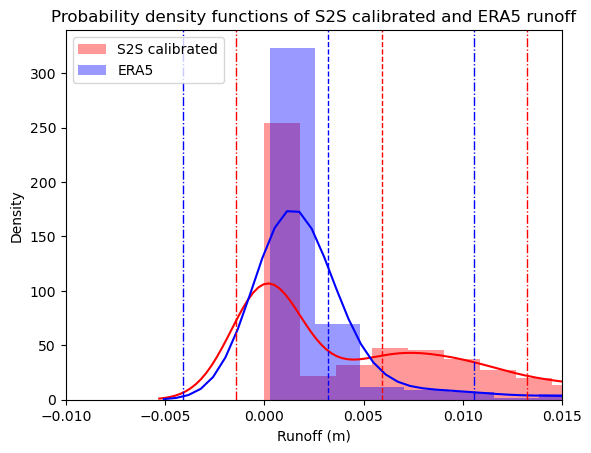

In [5]:
# define a function to calculate the calibration coefficient, c1
# for adjusting the variance of the S2S data to match the ERA5 data
def c1_coeff(S2S, ERA5):
    """Calculates the calibration coefficient, c1, for adjusting the variance of the S2S data to match the ERA5 data."""

    # load the data
    data = xr.open_dataset(S2S)
    era5 = xr.open_dataset(ERA5)

    # prepare the ERA5 data
    era5 = ERA5_data_matchup(era5)

    # calculate the calibration coefficient
    c1 = era5['ro'].std()/data['ro'].values.flatten().std()

    # return the calibration coefficient
    return c1

# define a function to calculate the calibration coefficient, c0
# for adjusting the mean of the S2S data to match the ERA5 data
def c0_coeff(S2S, ERA5):
    """Calculates the calibration coefficient, c0, for adjusting the mean of the S2S data to match the ERA5 data."""

    # load the data
    data = xr.open_dataset(S2S)
    era5 = xr.open_dataset(ERA5)

    # prepare the ERA5 data
    era5 = ERA5_data_matchup(era5)

    # calculate the calibration coefficient
    c0 = era5['ro'].mean() - (era5['ro'].std()/data['ro'].values.flatten().std()) *data['ro'].values.flatten().mean()

    # return the calibration coefficient
    return c0

# call the function and check the value
c1 = c1_coeff(uncal_S2S, era5_grid)
#print(c1.compute())

# call the function and check the value
c0 = c0_coeff(uncal_S2S, era5_grid)
print(c0.compute())


# set the name of the figure
fig_name = 'PDFs_S2S_calibrated_ERA5.png'
title = 'Probability density functions of S2S calibrated and ERA5 runoff'

# apply the calibration coefficient to the S2S data
# in the plotting function
plot_PDFs(uncal_S2S, era5_grid, title, fig_name, calibrate=True, c1=c1, c0=0)


### Q5 ###

For question 5 we want to run the model over the full duration of one S2S forecasts starting in June 2018.

For this we choose to use the 2018-06-21 data.

This data must be prepared so that we can loop over each of the individual members in python.

In [ ]:
%%bash

# first we will calculate the runoff for the 20180621 data
for i in {1..50}; do

    # extract the runoff data for the current ensemble member
    cdo selname,ro -sellevel,$i japan_ECMF_PF.20180621.nc japan_ECMF_PF.20180621.$i.nc

    # calculate the difference between the runoff at the current time step and the runoff at the previous time step within the file
    # put the output file in the 20180621 folder
    cdo -b f64 deltat japan_ECMF_PF.20180621.$i.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.nc

    # divide the runoff by 1000 to convert from kg m-2 to m3 s-1
    cdo divc,1000 /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.nc

    # remove the temporary files
    rm japan_ECMF_PF.20180621.$i.nc
    rm /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.nc

done

Then select our Tokuyama grid box.

In [ ]:
%%bash

# we then need to select the lat/lon box for the study area for each of the files
for i in {1..50}; do

    # select the lat/lon box for the study area
    cdo sellonlatbox,135,137,34,36 /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.nc

    # remove the temporary files
    rm /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.nc

done

# we then want to calculate the mean for the grid box for each of the ensemble members
for i in {1..50}; do

    # calculate the mean for the grid box
    cdo fldmean /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.nc

    # remove the temporary files
    rm /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.nc

done


Then apply the calibration (and recalibration).

In [ ]:
%%bash

# we want to calibrate the data using the c1 value
# this acts to scale the data to the observed data in ERA5

# define the c1 value
c1=2.057371428376461

# we then want to calculate the runoff for the 20180621 data
for i in {1..50}; do

    # perform the calibration
    cdo mulc,$c1 /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.calibrated.nc

    # remove the temporary files
    rm /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.nc

done

# for each of the ensemble members we want to divide by c1
# then multiply by the new c1 value

# define the new c1 value
new_c1=2.64497046

# initialise the for loop to loop over all of the ensemble members
for i in {1..50}; do

    # divide by c1
    cdo divc,$c1 /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.calibrated.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.calibrated.div-c1.nc

    # multiply by the new c1 value
    cdo mulc,$new_c1 /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.calibrated.div-c1.nc /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.recalibrated.nc

    # remove the temporary files
    rm /home/users/benhutch/MTMG50/S2S/ecmwf/20180621/japan_ECMF_PF.20180621.$i.diff.converted-units.study_area.mean.calibrated.div-c1.nc

done